# Wind Energy Toolbox ```wetb()```

In [1]:
%%capture
try:
  import wetb
except ModuleNotFoundError:
  %pip install wetb
  import wetb


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from wetb.fatigue_tools.fatigue import eq_load

# Fatigue load calculation


(2, 3)
Neq: 10, m: 3, Equivalent load: 2.6637, Expected equivalent load: 2.6637
Neq: 10, m: 6, Equivalent load: 2.8269, Expected equivalent load: 2.8269
Neq: 10, m: 12, Equivalent load: 2.9121, Expected equivalent load: 2.9121
Neq: 20, m: 3, Equivalent load: 2.1142, Expected equivalent load: 2.1142
Neq: 20, m: 6, Equivalent load: 2.5184, Expected equivalent load: 2.5184
Neq: 20, m: 12, Equivalent load: 2.7487, Expected equivalent load: 2.7487


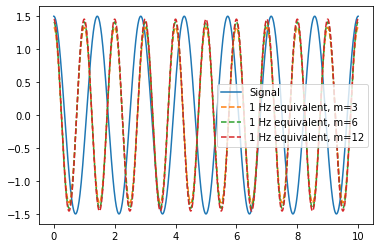

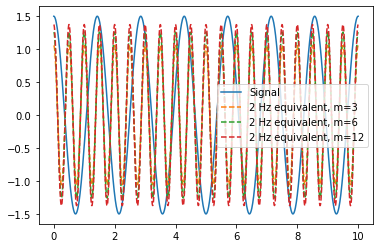

In [3]:
# Signal parameters
nr_periods = 7 
amplitude = 1.5
offset = 0

# Fatigue load parameters
m = [3,6,12] # Wöhler exponents
eq_freq =[1,2] # Frequency of equivalent signal

# Sinosodial signal
time = np.linspace(0, 10, 1000) #
neq = time[-1] * np.array(eq_freq)
signal = amplitude * np.cos(time/10*nr_periods*2*np.pi) + offset

# Equivalent load
eq_load_neq_m = np.array(eq_load(signal, m=m, neq=neq))
print((eq_load_neq_m.shape))

for eq_freq_, eq_load_m in zip(eq_freq, eq_load_neq_m):
  plt.figure()
  plt.plot(time, signal, label='Signal')
  for m_, eq_load in zip(m, eq_load_m):
    plt.plot(time, (eq_load/2) * np.cos(time*2*np.pi*eq_freq_), '--', label='%d Hz equivalent, m=%d'%(eq_freq_, m_))
    n_i = nr_periods # No cycles
    n_eq = 10*eq_freq_ # cycles in equivalent signal
    S_i = amplitude*2 # peak to peak amplitude
    expected_eq = np.round(((n_i * S_i**m_) / n_eq)**(1 / m_),4)
    print ("Neq: %d, m: %d, Equivalent load: %s, Expected equivalent load: %s"%(n_eq, m_, np.round(eq_load,4), expected_eq))
  plt.legend()

# Theory - Signals to Cycles

First the signal is reduced to only peak values (local minima and maxima) and then the number of cycles and their amplitude is found using rainflow counting. The plot below illustrates the principle and prints the amplitudes returned by the rainflow counting function.

('Amplitude of half cycles', [1.0, 1.0, 4.0, 4.0, 5.0, 8.0, 9.0])


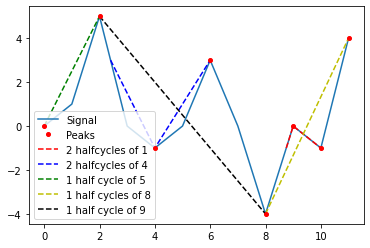

In [4]:
signal = np.array([-0, 1, 5, 0, -1, 0, 3, 0, -4, 0, -1,4])
plt.plot(signal, label='Signal')
plt.plot([0,2,4,6,8,9,10,11],[0,5,-1,3,-4,0,-1,4],'.r', ms=8, label='Peaks', zorder=32)

plt.plot([8.75,9,10],[-1,0,-1],'--r', label="2 halfcycles of 1")
plt.plot([2.4,4,6],[3,-1,3],'--b', label="2 halfcycles of 4")
plt.plot([0,2],[0,5],'--g', label="1 half cycle of 5")
plt.plot([8,11],[-4,4],'--y', label="1 half cycles of 8")
plt.plot([2,8],[5,-4],'--k', label="1 half cycle of 9")
plt.legend(loc='lower left')


from wetb.fatigue_tools.fatigue import rainflow_astm
ampl, mean = rainflow_astm(signal)
print(("Amplitude of half cycles", sorted(ampl)))

Note, that this is the number of half cycles, i.e. the number of full cycles ($n_i$ below) are:


| Cycles | Amplitude |
|--------|-----------|
| 1      | 1         |
| 1      | 4         |
| 0.5    | 5         |
| 0.5    | 8         |
| 0.5    | 9         |

# Cycles to equivalent load

The SN-curve specifies the relation between the stress, $S$, and the the number to failure, $N$. In other words, failure will occur after $N_i$ cycles with amplitude, $S_i$.

![](https://drive.google.com/uc?export=view&id=1_z2rioFKfh_mkzZq3lTAGYr2idSIevE-)

The damage factor, $d_i$, of $n_i$ cycles with amplitude, $S_i$ is: $d_i =\frac{n_i}{N_i}$
where $N_i$ is the number of cycles to failure for the amplitude, $S_i$ . According to the Palmgren-Miner linear damage hypothesis, this relation between stress and number to failure is linear in a log-log coodinate system with the slope: $\frac{1}{m}$ where $m$ is the Wöhler exponent This relation can be formulated as:
$N_i = \left(\frac{S_0}{S_i}\right)^m$
Inserting this into the equation above gives us an expression for the damage factor for a number of cycles, $n_i$ with amplitude $S_i$:
$d_i=\frac{n_i}{N_i} = \frac{n_i S_i^m}{S_0^m}$
The total damage, $D$, can be summed for cycles of differnce amplitudes:
$D=\frac{1}{S_0^m} \sum{n_i S_i^m}$
For a given number of cycles, $n_{eq}$, the amplitude, $S_{eq}$, that gives the same total damage can now be found:
$\frac{n_{eq}S_{eq}^m}{S_0^m}=D=\frac{1}{S_0^m} \sum{n_i S_i^m} \Rightarrow S_{eq}=\left(\frac{\sum{n_i S_i^m}}{n_{eq}}\right)^\frac{1}{m}$
The 1Hz equivalent stress is found by setting $n_{eq}$ to the signal length in second, i.e. the total damage of the signal is equal to the damage of a 1Hz sinododial signal of the same length with amplitude $S_{eq}$.